# Synthetic Dataset 1a: Linear

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import plot_tree

from sklearn.metrics import r2_score, classification_report, confusion_matrix,           \
                            roc_curve, roc_auc_score, plot_confusion_matrix, f1_score,   \
                            balanced_accuracy_score, accuracy_score, mean_squared_error, \
                            log_loss
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier,    \
                                 Lasso, lasso_path
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

import scipy
from scipy import stats

import os
import shutil
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import itertools

import time
import tqdm
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

import PIL
import joblib
import json

# import mysgd

In [20]:
# Import user-defined modules
import sys
import imp
sys.path.append('/Users/arbelogonzalezw/Documents/ML_WORK/LIBS/Lockout_copy/')
import tools_general as tg
import tools_pytorch as tp
import lockout       as ld
imp.reload(tg)
imp.reload(tp)
imp.reload(ld)

<module 'lockout' from '/Users/arbelogonzalezw/Documents/ML_WORK/LIBS/Lockout_copy/lockout.py'>

* ## Generate and save data

In [356]:
# Generate train, valid, & test datasets
# torch.manual_seed(42)
samples = 500
n_features = 100
pi = torch.Tensor([np.pi])

A1 = 2.0
A2 = -3.0
A3 = 4.0

xtrain = torch.rand(samples,n_features)
ytrain = torch.zeros(samples)
ytrain[:] = A1*xtrain[:,0] + A2*xtrain[:,1] + A3*xtrain[:,2]

xvalid = torch.rand(samples,n_features)
yvalid = torch.zeros(samples)
yvalid[:] = A1*xvalid[:,0] + A2*xvalid[:,1] + A3*xvalid[:,2]

xtest = torch.rand(samples,n_features)
ytest = torch.zeros(samples)
ytest[:] = A1*xtest[:,0] + A2*xtest[:,1] + A3*xtest[:,2]

y_std = ytrain.std()
print("MEAN of 'ytrain' before adding noise =", ytrain.mean().item())
print("STD of 'ytrain' before adding noise =", y_std.item())

y_std = 1.0*y_std
y_mean = 0.0
print("\nGaussian noise added to 'ytrain with:")
print("- mean =", y_mean)
print("- std =", y_std.item())

ynoise1 = torch.normal(mean=y_mean, std=y_std, size=(samples, 1))
ytrain[:] += ynoise1[:,0]
ynoise2 = torch.normal(mean=y_mean, std=y_std, size=(samples, 1))
yvalid[:] += ynoise2[:,0]

MEAN of 'ytrain' before adding noise = 1.349893569946289
STD of 'ytrain' before adding noise = 1.5365978479385376

Gaussian noise added to 'ytrain with:
- mean = 0.0
- std = 1.5365978479385376


In [357]:
# Convert to Pandas DataFrames
cols_X = [str(i) for i in range(1, n_features+1)]
df_xtrain = pd.DataFrame(xtrain.numpy(), columns=cols_X)
df_xvalid = pd.DataFrame(xvalid.numpy(), columns=cols_X)
df_xtest  = pd.DataFrame(xtest.numpy(), columns=cols_X)
cols_X = df_xtrain.columns.tolist()

cols_Y = ['target']
df_ytrain = pd.DataFrame(ytrain.numpy(), columns=cols_Y)
df_yvalid = pd.DataFrame(yvalid.numpy(), columns=cols_Y)
df_ytest = pd.DataFrame(ytest.numpy(), columns=cols_Y)

In [358]:
# Save Dataset
tg.save_data(df_xtrain, df_xtrain, df_xvalid, df_xtest, 
             df_ytrain, df_ytrain, df_yvalid, df_ytest, 'dataset_a/')
tg.save_list(cols_X, 'dataset_a/X.columns')
tg.save_list(cols_Y, 'dataset_a/Y.columns')

# 
print("- xtrain size: {}".format(df_xtrain.shape))
print("- xvalid size: {}".format(df_xvalid.shape))
print("- xtest size: {}".format(df_xtest.shape))

- xtrain size: (500, 100)
- xvalid size: (500, 100)
- xtest size: (500, 100)


* ## Load Data

In [3]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")
    
# Choose device
# torch.cuda.set_device(6)

-Type of precessor to be used: 'cpu'


In [4]:
# Read data
_, x_train, x_valid, x_test, _, y_train, y_valid, y_test = tp.load_data_reg('dataset_a/')
cols_X = tg.read_list('dataset_a/X.columns')
cols_Y = tg.read_list('dataset_a/Y.columns')

In [5]:
# Normalize data
xtrain, xvalid, xtest, ytrain, yvalid, ytest = tp.normalize_xy(x_train, x_valid, x_test, 
                                                               y_train, y_valid, y_test)

In [6]:
# Create dataloaders
dl_train, dl_valid, dl_test = tp.make_DataLoaders(xtrain, xvalid, xtest, ytrain, yvalid, ytest, 
                                                  tp.dataset_tabular, batch_size=10000)

(train, valid, test) = (1, 1, 1)


In [7]:
# NN architecture with its corresponding forward method
class MyNet(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNet, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(features, layer_sizes[0], bias=True)
        )

# .Forward function
    def forward(self, x):
        x = self.classifier(x)
        return x

In [22]:
# Instantiate model
n_features = len(cols_X)
n_layers = [1]
model = MyNet(n_features, n_layers)
model.eval()

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=1, bias=True)
  )
)

* ## Unregularized

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True
Last iteration = 1315
Best validation at iteration = 263


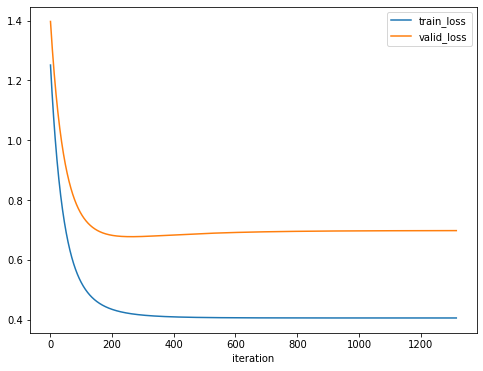

In [35]:
# TRAIN FORWARD
lockout_unconstraint = ld.Lockout(model, lr=5e-3, loss_type=1, optim_id=1, 
                                  save_weights=(True, 'classifier.0.weight'))

lockout_unconstraint.train(dl_train, dl_valid, epochs=10000, early_stop=20, tol_loss=1e-7,
                           train_how="unconstraint", reset_weights=True)

lockout_unconstraint.path_data.plot(x="iteration", 
                                    y=['train_loss', 'valid_loss'], 
                                    figsize=(8,6))
plt.show()

In [36]:
# Save model, data
tp.save_model(lockout_unconstraint.model_best_valid, 'outputs_a/model_forward_valid_min_a.pth')
tp.save_model(lockout_unconstraint.model_last, 'outputs_a/model_forward_last_a.pth')
lockout_unconstraint.path_data.to_csv('outputs_a/data_forward_a.csv')
lockout_unconstraint.weight_iters.to_csv('outputs_a/w_vs_iters_forward.csv', header=None, index=False)

In [37]:
# Accuracy
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./outputs_a/model_forward_valid_min_a.pth'))
mm.eval()

xtrain = xtrain.to(device)
ypred = mm(xtrain)
r2 = r2_score(ytrain.detach().numpy(), ypred.detach().numpy())
print("Train R2 = {:.4f}".format(r2))

xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
print("Valid R2 = {:.4f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
print("Test R2  = {:.4f}".format(r2))

Train R2 = 0.5808
Valid R2 = 0.3702
Test R2  = 0.7809


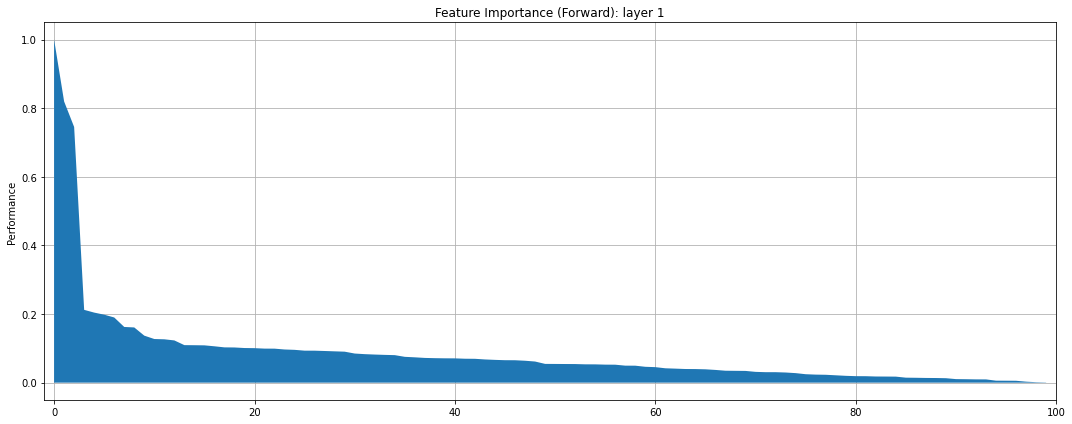

Non zero features: 100


In [38]:
# Weight importance (layer 1)
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./outputs_a/model_forward_valid_min_a.pth'))
mm.eval()

importance = tp.get_features_importance(mm, 'classifier.0.weight')

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(len(importance))
axes.fill_between(x_pos, importance, zorder=2)
# axes.set_xticks(x_pos)
# axes.set_xticklabels(feature_importance_sorted1.index[idx], rotation='vertical')
axes.set_xlim(-1,len(x_pos))
axes.set_ylabel('Performance')
axes.set_title('Feature Importance (Forward): layer 1')
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig('outputs_a/feature_importance_forward_a.pdf', bbox_inches='tight')
plt.show()
print("Non zero features: {}".format(len(importance)))

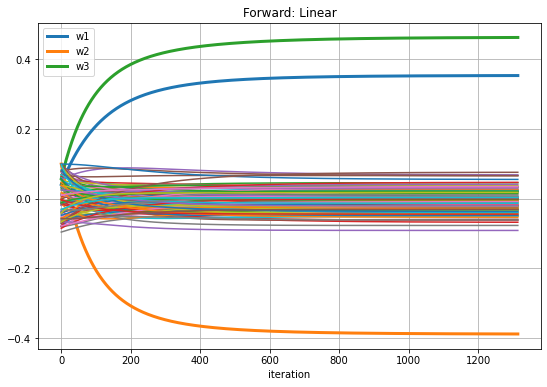

In [39]:
# Plot weights vs iters
ww_iter = pd.read_csv('outputs_a/w_vs_iters_forward.csv', header=None)
ncols = ww_iter.shape[1]
iters = ww_iter.index.tolist()

fig, axes = plt.subplots(figsize=(9,6))
for i in range(ncols):
    if i < 3:
        axes.plot(iters, ww_iter[i], label="w{}".format(i+1), linewidth=3)
    else:
        axes.plot(iters, ww_iter[i])

axes.set_xlabel("iteration")
axes.set_title("Forward: Linear")
axes.legend()
axes.grid(True, zorder=2)

plt.savefig("outputs_a/w_vs_iters_forward.pdf", bbox_inches='tight')
plt.show()

* ## Lockout

In [40]:
# TRAIN WITH LOCKOUT
model = MyNet(n_features, n_layers)
model.load_state_dict(torch.load('./outputs_a/model_forward_last_a.pth'))
model.eval()

regul_type = [('classifier.0.weight', 1)]
regul_path = [('classifier.0.weight', True)]

lockout_reg = ld.Lockout(model, lr=1e-2, 
                           regul_type=regul_type,
                           regul_path=regul_path, 
                           loss_type=1, tol_grads=1e-3, 
                           save_weights=(True, 'classifier.0.weight'))

In [41]:
lockout_reg.train(dl_train, dl_valid, dl_test, epochs=20000, early_stop=20, tol_loss=1e-5,
                  train_how="decrease_t0")

Epochs1:   0%|          | 0/20000 [00:00<?, ?it/s]

Path 1: Early stopping = True
        Last iteration = 20


Epochs2:   0%|          | 0/20000 [00:00<?, ?it/s]

Best validation at iteration = 14557


In [42]:
# Save model, data
tp.save_model(lockout_reg.model_best_valid, 'outputs_a/model_lockout_valid_min_a.pth')
tp.save_model(lockout_reg.model_last, 'outputs_a/model_lockout_last_a.pth')
lockout_reg.path_data.to_csv('outputs_a/data_lockout_a.csv')
lockout_reg.weight_iters.to_csv('outputs_a/w_vs_iters_lockout.csv', header=None, index=False)

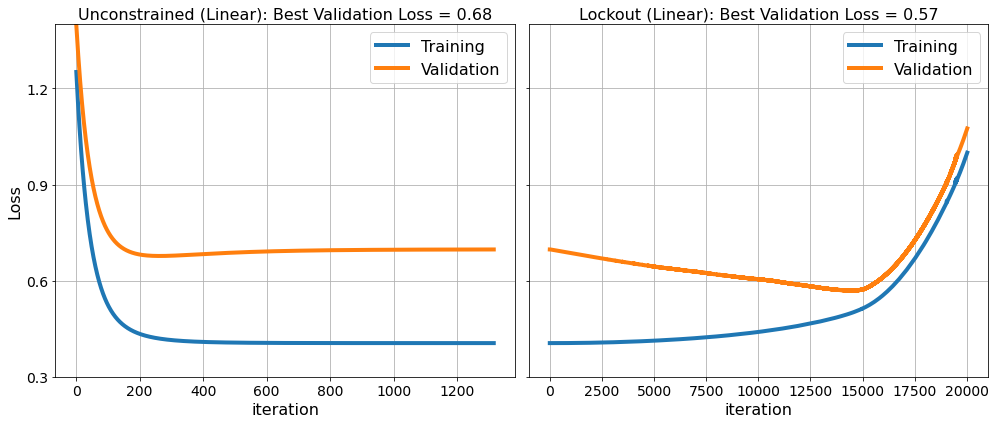

In [45]:
# Plot unconstrained + lockout loss vs iteration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df1 = pd.read_csv('outputs_a/data_forward_a.csv')
df2 = pd.read_csv('outputs_a/data_lockout_a.csv')

axes[0].set_ylim(0.3, 1.4)
axes[0].plot(df1["iteration"], df1["train_loss"], label="Training", linewidth=4)
axes[0].plot(df1["iteration"], df1["valid_loss"], label="Validation", linewidth=4)
axes[0].legend(fontsize=16)
axes[0].set_xlabel("iteration", fontsize=16)
axes[0].set_ylabel("Loss", fontsize=16)
axes[0].set_yticks(np.arange(0.3, 1.4, 0.3))
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_title("Unconstrained (Linear): Best Validation Loss = {:.2f}".format(df1["valid_loss"].min()), 
                  fontsize=16)
axes[0].grid(True, zorder=2)

axes[1].set_ylim(0.3, 1.4)
axes[1].plot(df2["iteration"], df2["train_loss"], label="Training", linewidth=4)
axes[1].plot(df2["iteration"], df2["valid_loss"], label="Validation", linewidth=4)
axes[1].legend(fontsize=16)
axes[1].set_xlabel("iteration", fontsize=16)
axes[1].set_yticks(np.arange(0.3, 1.4, 0.3))
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_yticklabels([])
axes[1].set_title("Lockout (Linear): Best Validation Loss = {:.2f}".format(df2["valid_loss"].min()), 
                  fontsize=16)
axes[1].grid(True, zorder=2)

plt.tight_layout()
plt.savefig("outputs_a/loss_vs_iter_a.pdf", bbox_inches='tight')
plt.show()

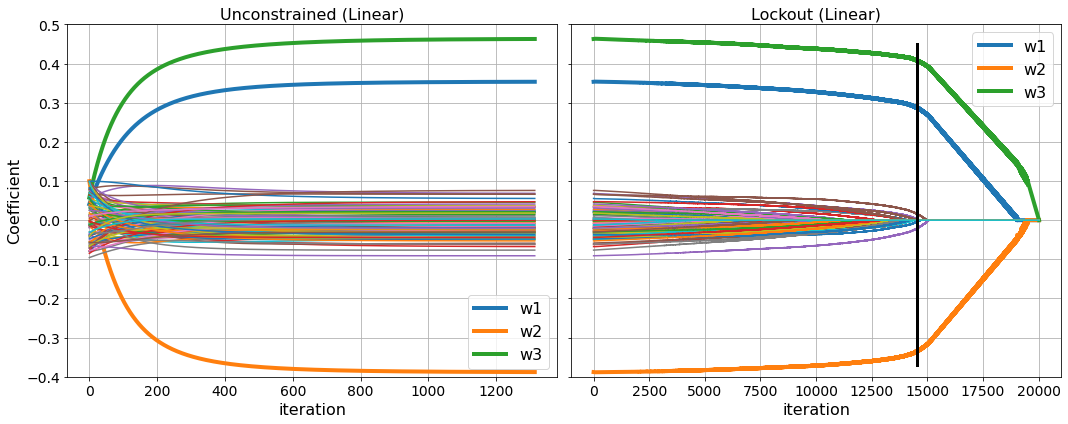

In [46]:
# Plot weights vs iters
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

# Forward
ww_iter = pd.read_csv('outputs_a/w_vs_iters_forward.csv', header=None)
ncols = ww_iter.shape[1]
iters = ww_iter.index.tolist()
for i in range(ncols):
    if i < 3:
        axes[0].plot(iters, ww_iter[i], label="w{}".format(i+1), linewidth=4)
    else:
        axes[0].plot(iters, ww_iter[i])

axes[0].set_xlabel("iteration", fontsize=16)
axes[0].set_ylabel("Coefficient", fontsize=16)
axes[0].set_title("Unconstrained (Linear)", fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].legend(fontsize=16)
axes[0].grid(True, zorder=2)
axes[0].set_ylim(-0.4, 0.5)

# lockout
ww_iter = pd.read_csv('outputs_a/w_vs_iters_lockout.csv', header=None)
ncols = ww_iter.shape[1]
iters = ww_iter.index.tolist()
for i in range(ncols):
    if i < 3:
        axes[1].plot(iters, ww_iter[i], label="w{}".format(i+1), linewidth=4)
    else:
        axes[1].plot(iters, ww_iter[i])

axes[1].set_xlabel("iteration", fontsize=16)
axes[1].set_title("Lockout (Linear)", fontsize=16)
axes[1].legend(fontsize=16)
axes[1].set_yticklabels([])
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].grid(True, zorder=2)
axes[1].set_ylim(-0.4, 0.5)
axes[1].plot([14557, 14557],[-.37, .45], linewidth=3, color='black')

plt.tight_layout()
plt.savefig("outputs_a/w_vs_iters_a.pdf", bbox_inches='tight')
plt.show()

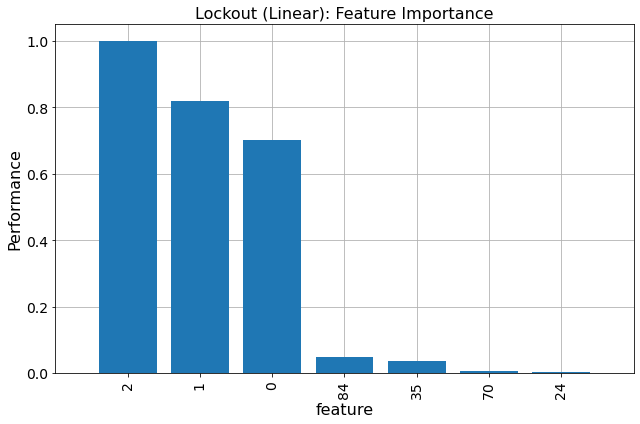

Non zero features: 7


In [47]:
# Features importance (layer 1)
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./outputs_a/model_lockout_valid_min_a.pth'))
mm.eval()

importance = tp.get_features_importance(mm, 'classifier.0.weight')

fig, axes = plt.subplots(figsize=(9,6))
x_pos = np.arange(len(importance))
axes.bar(x_pos, importance, zorder=2)
axes.set_xticks(x_pos)
axes.set_xticklabels(importance.index, rotation='vertical')
axes.set_xlim(-1,len(x_pos))
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_ylabel('Performance', fontsize=16)
axes.set_xlabel('feature', fontsize=16)
axes.set_title('Lockout (Linear): Feature Importance', fontsize=16)
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig('outputs_a/feature_importance_lockout_dataset_a.pdf', bbox_inches='tight')
plt.show()
print("Non zero features: {}".format(len(importance)))

In [52]:
# Accuracy
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./outputs_a/model_lockout_valid_min_a.pth'))
mm.eval()

print("lockout:")
xtrain = xtrain.to(device)
ypred = mm(xtrain)
r2 = r2_score(ytrain.numpy(), ypred.detach().numpy())
print("Train R2 = {:.3f}".format(r2))

xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.numpy(), ypred.detach().numpy())
print("Valid R2 = {:.3f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.numpy(), ypred.detach().numpy())
print("Test R2  = {:.3f}".format(r2))

lockout:
Train R2 = 0.498
Valid R2 = 0.471
Test R2  = 0.958


In [53]:
# Accuracy
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./outputs_a/model_forward_valid_min_a.pth'))
mm.eval()

print("Early Stopping:")
xtrain = xtrain.to(device)
ypred = mm(xtrain)
r2 = r2_score(ytrain.numpy(), ypred.detach().numpy())
print("Train R2 = {:.3f}".format(r2))

xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.numpy(), ypred.detach().numpy())
print("Valid R2 = {:.3f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.numpy(), ypred.detach().numpy())
print("Test R2  = {:.3f}".format(r2))

Early Stopping:
Train R2 = 0.581
Valid R2 = 0.370
Test R2  = 0.781


In [54]:
# Error
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./outputs_a/model_lockout_valid_min_a.pth'))
mm.eval()

print("lockout:")
xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.numpy(), ypred.detach().numpy())
r2 = np.sqrt(1.0 - r2)
print("Valid Error = {:.3f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.numpy(), ypred.detach().numpy())
r2 = np.sqrt(1.0 - r2)
print("Test Error  = {:.3f}".format(r2))

lockout:
Valid Error = 0.727
Test Error  = 0.204


In [55]:
# Error
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./outputs_a/model_forward_valid_min_a.pth'))
mm.eval()

print("Early Stopping:")
xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
r2 = np.sqrt(1.0 - r2)
print("Valid Error = {:.3f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
r2 = np.sqrt(1.0 - r2)
print("Test Error  = {:.3f}".format(r2))

Early Stopping:
Valid Error = 0.794
Test Error  = 0.468
